### Topic Modeling on TED Talks.

#### The data files were taken from https://www.kaggle.com/rounakbanik/ted-talks


In [ ]:
# Imports

import numpy as np 
import pandas as pd 
from time import time
import ast
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


Loading the Transcripts

In [2]:
main_df = pd.read_csv('data/ted_main.csv', encoding = 'utf-8')
transcripts_df = pd.read_csv('data/transcripts.csv', encoding = 'utf-8')
transcripts_df.head()

In [3]:
stopwords = text.ENGLISH_STOP_WORDS.union(["ca","ll","didn","000"])
print(len(stopwords))
# print(stopwords)

322


In [4]:
# Consider words which have have frequency between 5 and 60 percent only and vectorize them
vectorizer = TfidfVectorizer(stop_words = stopwords, min_df = 0.05, max_df = 0.60)
t0 = time()
tfidf = vectorizer.fit_transform(transcripts_df['transcript'])
print("done in %0.3fs." % (time() - t0))

done in 4.447s.


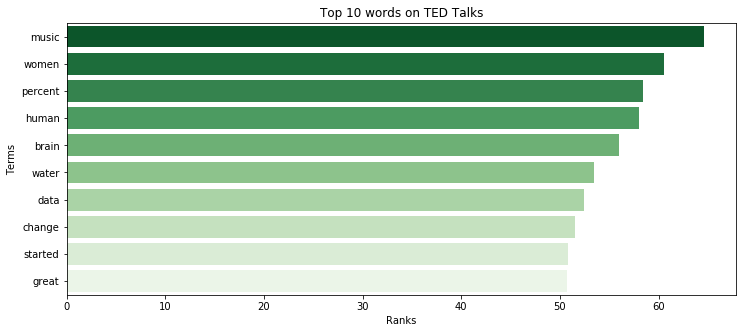

In [5]:
# Let's make a function to call the top ranked words in a vectorizer
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis = 0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns = ['Terms','Ranks']).sort_values('Ranks', ascending = False)
    return ranked

ranked = rank_words(terms = vectorizer.get_feature_names(), feature_matrix = tfidf)
fig, ax = plt.subplots(figsize = (12,5), ncols = 1, nrows = 1)
plt.title('Top 10 words on TED Talks')
sns.barplot(x = 'Ranks', y = 'Terms', data = ranked[:10], palette = 'Greens_r', ax = ax);

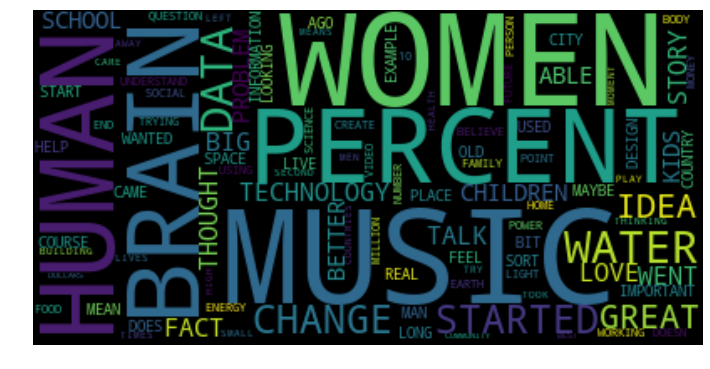

In [6]:
dic = {ranked.loc[i,'Terms'].upper(): ranked.loc[i,'Ranks'] for i in range(0,len(ranked))}
wordcloud = WordCloud(background_color = 'black', max_words = 100).generate_from_frequencies(dic)
fig = plt.figure(1,figsize = (12,12))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [7]:
numTopics = 10
tsvd = TruncatedSVD(n_components = numTopics, n_iter = 100)

topics = tsvd.fit_transform(tfidf)
top_n_words = 5
top_words, scores = {}, {}
print("Top five words and their scores\n")
for t_id, t in enumerate(tsvd.components_):
    top_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    scores[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    print("Topic {}:".format(t_id))
    print(top_words[t_id])
    print(scores[t_id])
    print("\n")

Top five words and their scores

Topic 0:
['women', 'human', 'percent', 'brain', 'great']
[0.08334363 0.08100297 0.08068889 0.07366409 0.07081574]


Topic 1:
['women', 'men', 'woman', 'girls', 'children']
[0.38406326 0.17669322 0.12323202 0.12247739 0.11711906]


Topic 2:
['music', 'play', 'sound', 'video', 'brain']
[0.75917285 0.11922783 0.10838259 0.08937885 0.08764386]


Topic 3:
['brain', 'cells', 'cancer', 'women', 'body']
[0.44521502 0.25480967 0.24466156 0.12897032 0.12861418]


Topic 4:
['music', 'data', 'cancer', 'countries', 'health']
[0.38153016 0.18507503 0.1517257  0.11828976 0.11815459]


Topic 5:
['music', 'women', 'water', 'cancer', 'cells']
[0.31419206 0.28554783 0.20317895 0.20044548 0.15930486]


Topic 6:
['women', 'brain', 'universe', 'men', 'data']
[0.37065676 0.20021761 0.15472156 0.15226643 0.11599457]


Topic 7:
['brain', 'children', 'kids', 'food', 'africa']
[0.43548268 0.13831126 0.11951032 0.10535876 0.08479445]


Topic 8:
['brain', 'city', 'cities', 'design'

In [8]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=3, verbose=1, random_state=44, angle=.50,
                  perplexity=18,early_exaggeration=1,learning_rate=50.0)#, init='pca'

# 20-D -> 3-D
tsne_lda = tsne_model.fit_transform(topics)

[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 2467 samples in 0.003s...
[t-SNE] Computed neighbors for 2467 samples in 0.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2467
[t-SNE] Computed conditional probabilities for sample 2000 / 2467
[t-SNE] Computed conditional probabilities for sample 2467 / 2467
[t-SNE] Mean sigma: 0.061155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.619014
[t-SNE] KL divergence after 1000 iterations: 1.403309


In [9]:
# tsne_data = pd.DataFrame(tsne_lda)
plot_tsne(tsne_lda,y, 0, 60)

NameError: name 'plot_tsne' is not defined

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
plt.subplots_adjust(left = 0.05, right = 0.95, top = 0.8, bottom = 0.2, hspace = 0, wspace = 0)
# mask for wordcloud
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

for i in range(3):
    for j in range(3):
        cluster = {}
        for word in top_words[i * 3 + j]:
            cluster[word] = 1
        wc = WordCloud(background_color = 'white', mask = mask).generate_from_frequencies(cluster)
        ax[i,j].imshow(wc, interpolation = 'bilinear')
        ax[i,j].axis("off")

In [ ]:
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('tsvd', tsvd)
])

document_id = 852
t = pipe.transform([transcripts_df['transcript'].iloc[document_id]]) 
threshold = 0.1
for i, p in enumerate(t[0]):
    if p>threshold:
        print('Document number {} talk about topic #{}'.format(document_id, i))
print('\nTranscript:')     
print(transcripts_df['transcript'].iloc[document_id][:750],'...')

talk = main_df[main_df['url']==transcripts_df['url'].iloc[document_id]]
print('\nActual tags from ted_main.csv: \n', talk['tags'].values)
talk

In [ ]:
numTopics = 10
lda = LatentDirichletAllocation(n_components = numTopics, random_state = 0, learning_method = 'batch')
topics = lda.fit_transform(tfidf)
top_n_words = 5

top_words, scores = {}, {}
print("Top five words and their scores\n")
for t_id, t in enumerate(lda.components_):
    top_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    scores[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    print("Topic {}:".format(t_id))
    print(top_words[t_id])
    print(scores[t_id])
    print("\n")

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
plt.subplots_adjust(left = 0.05, right = 0.95, top = 0.8, bottom = 0.2, hspace = 0, wspace = 0)
# mask for wordcloud
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

for i in range(3):
    for j in range(3):
        cluster = {}
        for word in top_words[i * 3 + j]:
            cluster[word] = 1
        wc = WordCloud(background_color = 'white', mask = mask).generate_from_frequencies(cluster)
        ax[i,j].imshow(wc, interpolation = 'bilinear')
        ax[i,j].axis("off")

In [ ]:
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('lda', lda)
])

document_id = 852
t = pipe.transform([transcripts_df['transcript'].iloc[document_id]]) 
threshold = 0.1
for i, p in enumerate(t[0]):
    if p>threshold:
        print('Document number {} talk about topic #{}'.format(document_id, i))
print('\nTranscript:')     
print(transcripts_df['transcript'].iloc[document_id][:750],'...')

talk = main_df[main_df['url']==transcripts_df['url'].iloc[document_id]]
print('\nActual tags from ted_main.csv: \n', talk['tags'].values)
talk

In [ ]:
#NMF
numTopics = 10
nmf = NMF(n_components = numTopics, init = 'random', random_state = 0)

topics = nmf.fit_transform(tfidf)

top_n_words = 5
top_words, scores = {}, {}
print("Top five words and their scores\n")
for t_id, t in enumerate(nmf.components_):
    top_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    scores[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    print("Topic {}:".format(t_id))
    print(top_words[t_id])
    print(scores[t_id])
    print("\n")

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
plt.subplots_adjust(left = 0.05, right = 0.95, top = 0.8, bottom = 0.2, hspace = 0, wspace = 0)
# mask for wordcloud
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

for i in range(3):
    for j in range(3):
        cluster = {}
        for word in top_words[i * 3 + j]:
            cluster[word] = 1
        wc = WordCloud(background_color = 'white', mask = mask).generate_from_frequencies(cluster)
        ax[i,j].imshow(wc, interpolation = 'bilinear')
        ax[i,j].axis("off")

In [ ]:
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

document_id = 852
t = pipe.transform([transcripts_df['transcript'].iloc[document_id]]) 
threshold = 0.1
for i, p in enumerate(t[0]):
    if p>threshold:
        print('Document number {} talk about topic #{}'.format(document_id, i))
print('\nTranscript:')     
print(transcripts_df['transcript'].iloc[document_id][:750],'...')

talk = main_df[main_df['url']==transcripts_df['url'].iloc[document_id]]
print('\nActual tags from ted_main.csv: \n', talk['tags'].values)
talk